In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from itertools import product

## Process data
Import the CSVs storing each experiment's results, put it together into a DataFrame, and compute some metrics

In [2]:
typ = "lin"
directory = '{}_rate/'.format(typ)
outdir = 'figs/'

In [3]:
# Compute a 95% CI for the quantity Y/X

def ratio_of_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean_x, mean_y = x.mean(axis=0), y.mean(axis=0)
    s_x, s_y, s_xy = x.std(axis=0), y.std(axis=0), x.cov(y)
    
    c_xx, c_yy = s_x**2 / (mean_x**2 * sample_size), s_y**2 / (mean_y**2 * sample_size)
    c_xy = s_xy / (mean_x * mean_y * sample_size)
    
    mid = 1-(tee**2)*c_xy
    half = tee*np.sqrt(c_xx + c_yy - 2*c_xy - tee**2 * (c_xx*c_yy - c_xy**2))
    scale = mean_y/(mean_x * (1-(tee**2)*c_xx))
    
    lower, upper = scale*(mid - half), scale*(mid+half)
    raw = mean_y/mean_x

    return [1-raw, upper-raw, raw-lower]

def diff_of_means(x, y, sample_size):
    
    tee = t.ppf(0.975, sample_size-1)

    mean_x, mean_y = x.mean(axis=0), y.mean(axis=0)
    s_x, s_y = x.std(axis=0), y.std(axis=0)
    
    mid = mean_x - mean_y
    half = tee*np.sqrt(s_x**2/sample_size + s_y**2/sample_size)
    
    return [mid, half, half]

Compute the relative cost difference of using the fluid policy w/r/t the equilibrium policy and the simple policy.

In [4]:
all_dfs = []

times = []
param_settings = []
default_params = {
    'lambda' : 9.8,
    'nu' : 1/15,
    'mu' : 1/4,
    'h' : 0.2,
    'r' : 1.0,
    'C' : "lambda p: 10*1.0*(0.2-p)",
    'x_0' : 100,
    'y_0' : 100,
    'fluctuation': 0,
    'period': 1
}
with open(directory + "sims.log", "r") as logs:
    for line in logs.readlines():
        start = line.find("{")
        times.append(line[:start - 1])
        params = default_params.copy()
        params.update(eval(line[start:-2]))
        param_settings.append(params)

paths = sorted([file for file in os.listdir(directory) if file.endswith('.csv')])
for file, params in zip(paths, param_settings):
    df = pd.read_csv(directory + file, index_col=0)
    for param, val in params.items():
        df[param] = val
    all_dfs.append(df)

df = pd.concat(all_dfs).reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
df['init'] = [str(tup) for tup in zip(df['x_0'], df['y_0'])]
df.init.mask(df.x_0 == 0, 'Long-run', inplace=True)
# df['init'] = [a + '/' + b for a, b in zip(np.where(df['x_0'] < 50, 'lo', 'hi'), np.where(df['y_0'] < 50, 'lo', 'hi'))]
df.drop(columns=['x_0', 'y_0'], inplace=True)

In [6]:
df['M'] = df['C'].str[14:-11].astype(float) if typ == 'quad' else df['C'].str[13:-8].astype(float)
df.drop(columns=['C'], inplace=True)

In [7]:
groupers = ['scale', 'init', 'lambda', 'nu', 'h', 'M', 'period', 'fluctuation', 'reps']
grouped = df.groupby(by=groupers)#, as_index=False)

In [8]:
stat = 'total_cost'

In [9]:
raw_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[0])
below_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[1])
above_eq_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat], x[stat + '.2'], len(x))[2])

raw_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[0])
below_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[1])
above_simple_rel = 100*grouped.apply(lambda x: ratio_of_means(x[stat+ '.1'], x[stat + '.2'], len(x))[2])

In [10]:
raw_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[0]) / grouped.run_length.mean()
below_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[1]) / grouped.run_length.mean()
above_eq = grouped.apply(lambda x: diff_of_means(x[stat], x[stat + '.2'], len(x))[2]) / grouped.run_length.mean()

raw_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[0]) / grouped.run_length.mean()
below_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[1]) / grouped.run_length.mean()
above_simple = grouped.apply(lambda x: diff_of_means(x[stat + '.1'], x[stat + '.2'], len(x))[2]) / grouped.run_length.mean()

In [11]:
p_eq = grouped['mean_p'].mean()
p_ci_eq = grouped['mean_p'].std() / np.sqrt(grouped.size())
p_simple = grouped['mean_p.1'].mean()
p_ci_simple = grouped['mean_p.1'].std() / np.sqrt(grouped.size())
p_opt = grouped['mean_p.2'].mean()
p_ci_opt = grouped['mean_p.2'].std() / np.sqrt(grouped.size())

In [12]:
cong_time_eq = grouped['mean_congested_time'].mean()
cong_time_ci_eq = grouped['mean_congested_time'].std() / np.sqrt(grouped.size())
cong_time_simple = grouped['mean_congested_time.1'].mean()
cong_time_ci_simple = grouped['mean_congested_time.1'].std() / np.sqrt(grouped.size())
cong_time_opt = grouped['mean_congested_time.2'].mean()
cong_time_ci_opt = grouped['mean_congested_time.2'].std() / np.sqrt(grouped.size())

In [13]:
p_time_eq = grouped['mean_p_time'].mean()
p_time_ci_eq = grouped['mean_p_time'].std() / np.sqrt(grouped.size())
p_time_simple = grouped['mean_p_time.1'].mean()
p_time_ci_simple = grouped['mean_p_time.1'].std() / np.sqrt(grouped.size())
p_time_opt = grouped['mean_p_time.2'].mean()
p_time_ci_opt = grouped['mean_p_time.2'].std() / np.sqrt(grouped.size())

In [14]:
opt_mean = grouped[stat + '.2'].mean() / grouped.run_length.mean()
opt_ci = grouped[stat + '.2'].std() / np.sqrt(grouped.size()) / grouped.run_length.mean()
eq_mean = grouped[stat].mean() / grouped.run_length.mean()
eq_ci = grouped[stat].std() / np.sqrt(grouped.size()) / grouped.run_length.mean()
simple_mean = grouped[stat + '.1'].mean() / grouped.run_length.mean()
simple_ci = grouped[stat + '.1'].std() / np.sqrt(grouped.size()) / grouped.run_length.mean()

In [15]:
new_df = pd.concat([raw_eq, below_eq, above_eq,
                    raw_simple, below_simple, above_simple,
                    raw_eq_rel, below_eq_rel, above_eq_rel,
                    raw_simple_rel, below_simple_rel, above_simple_rel,#],
                    opt_mean, opt_ci, eq_mean, eq_ci, simple_mean, simple_ci,
                    p_eq, p_ci_eq, p_simple, p_ci_simple, p_opt, p_ci_opt,
                    p_time_eq, p_time_ci_eq, p_time_simple, p_time_ci_simple, p_time_opt, p_time_ci_opt,
                    cong_time_eq, cong_time_ci_eq, cong_time_simple, cong_time_ci_simple, cong_time_opt, cong_time_ci_opt,
                   ],
                   axis=1).reset_index()
groupers[2] = 'rate'
new_df.columns = groupers + [
                  'raw_eq', 'below_eq', 'above_eq', 'raw_simple', 'below_simple', 'above_simple',
                  'raw_eq_rel', 'below_eq_rel', 'above_eq_rel', 'raw_simple_rel', 'below_simple_rel', 'above_simple_rel',#]
                  'opt_mean', 'opt_ci', 'eq_mean', 'eq_ci', 'simple_mean', 'simple_ci',
                  'p_eq', 'p_ci_eq', 'p_simple', 'p_ci_simple', 'p_opt', 'p_ci_opt',
                  'p_time_eq', 'p_time_ci_eq', 'p_time_simple', 'p_time_ci_simple', 'p_time_opt', 'p_time_ci_opt',
                  'cong_time_eq', 'cong_time_ci_eq', 'cong_time_simple', 'cong_time_ci_simple', 'cong_time_opt', 'cong_time_ci_opt'
                 ]

## Plotting
Isolate the effect of each parameter: hold all others fixed (i.e. group by the other parameters, and then analyze each group separately), and plot against the parameter being varied.

In [16]:
grays = ['green', 'teal', 'blue', 'black']

In [17]:
rates = sorted(new_df.rate.unique())
scales = sorted(new_df.scale.unique())
hs = sorted(new_df.h.unique())
Ms = sorted(new_df.M.unique())
inits = sorted(new_df.init.unique())
nus = sorted(new_df.nu.unique())

fluctuations = sorted(new_df.fluctuation.unique())
periods = sorted(new_df.period.unique())

## Mean intervention (time-wise)

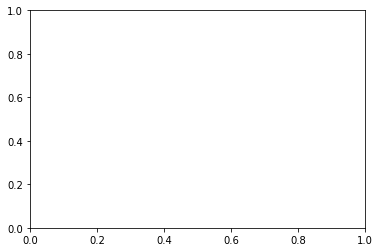

In [18]:
# Plot all together, for Python interpretation
fig, axes = plt.subplots(1,len(Ms), sharey=True)
for j, per in enumerate(periods):
    continue
    ax = axes[j]
    for k, init in enumerate(inits):
        subset = new_df[(new_df.M == M) & (new_df['init'] == init)].sort_values(by='h')
        ax.errorbar(subset['fluctuation'], (0.2 - subset.p_eq)/0.1 , yerr=subset.p_ci_eq,
                    capsize=2, color=grays[k])
        ax.errorbar(subset['fluctuation'], (0.2 - subset.p_simple)/0.1 , yerr=subset.p_ci_simple,
                    capsize=2, color=grays[k])
        ax.errorbar(subset['fluctuation'], (0.2 - subset.p_opt)/0.1 , yerr=subset.p_ci_opt,
                    capsize=2, color=grays[k])

    ax.set_xlabel("Arrival rate flucuation (relative)")
    ax.title.set_text("Period={}".format(per))

    fig.set_figheight(4)
    fig.set_figwidth(16)
    fig.suptitle("Proportion of patients receiving intervening ($\lambda = {}$)".format(rate*scale/50))
# plt.savefig(outdir + "figs/intervention_{}_{}.png".format(typ, rate), bbox_inches='tight')

In [19]:
# Plot all together, for Python interpretation
for scale, rate in product(scales, rates):
    continue 
    
    fig, axes = plt.subplots(1,len(rates), sharey=True)
    for j, per in enumerate(periods):
        ax = axes[j]
        for k, init in enumerate(inits):
            subset = new_df[(new_df['rate'] == rate) & (new_df['init'] == init) & (new_df['period'] == per) & (new_df['scale'] == scale)].sort_values(by='h')
            ax.errorbar(subset['fluctuation'], (0.2 - subset.p_time_eq)/0.1 , yerr=subset.p_time_ci_eq/0.1,
                        capsize=2, color=grays[k])
            ax.errorbar(subset['fluctuation'], (0.2 - subset.p_time_simple)/0.1 , yerr=subset.p_time_ci_simple/0.1,
                        capsize=2, color=grays[k])
            ax.errorbar(subset['fluctuation'], (0.2 - subset.p_time_opt)/0.1 , yerr=subset.p_time_ci_opt/0.1,
                        capsize=2, color=grays[k])
        
        ax.set_xlabel("Arrival rate flucuation (relative)")
        ax.title.set_text("Period={}".format(per))
        
    fig.set_figheight(4)
    fig.set_figwidth(16)
    fig.suptitle("Proportion of time spent intervening ($\lambda = {}$)".format(rate*scale/50))
    plt.savefig(outdir + "figs/intervention_time_{}_{}.png".format(typ, rate), bbox_inches='tight')

## Mean intervention

In [20]:
# Plot all together, for Python interpretation
for scale, rate in product(scales, rates):
    continue
    
    fig, axes = plt.subplots(1,len(rates), sharey=True)
    for j, per in enumerate(periods):
        ax = axes[j]
        for k, init in enumerate(inits):
            subset = new_df[(new_df['rate'] == rate) & (new_df['init'] == init) & (new_df['period'] == per) & (new_df['scale'] == scale)].sort_values(by='h')
            ax.errorbar(subset['fluctuation'], subset.cong_time_eq, yerr=subset.cong_time_ci_eq,
                        capsize=2, color=grays[k])
            ax.errorbar(subset['fluctuation'], subset.cong_time_simple, yerr=subset.cong_time_ci_simple,
                        capsize=2, color=grays[k])
            ax.errorbar(subset['fluctuation'], subset.cong_time_opt, yerr=subset.cong_time_ci_opt,
                        capsize=2, color=grays[k])
        
        ax.set_xlabel("Arrival rate flucuation (relative)")
        ax.title.set_text("Period={}".format(per))
        
    fig.set_figheight(4)
    fig.set_figwidth(16)
    fig.suptitle("Proportion of time spent congested ($\lambda = {}$)".format(rate*scale/50))
    plt.savefig(outdir + "figs/congestion_{}_{}.png".format(typ, rate), bbox_inches='tight')

## Performance Plot

### Line styles:
- Solid: fluid policy vs equilibrium policy
- Dot/dash: fluid safety policy vs equilbirium policy
- Dash: fluid policy vs simple policy
- Dot: fluid safety policy vs simple policy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

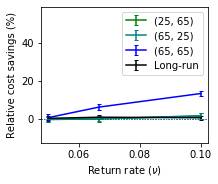

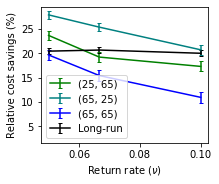

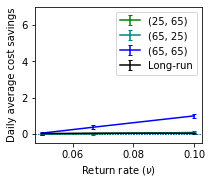

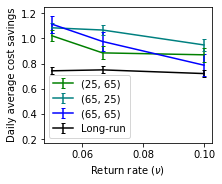

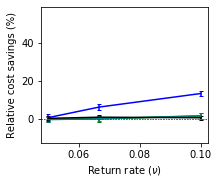

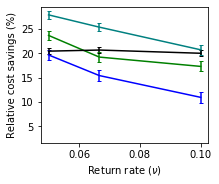

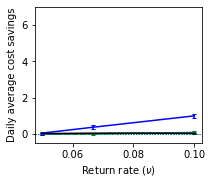

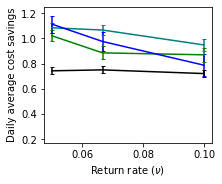

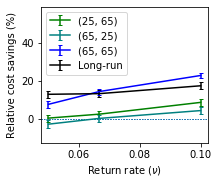

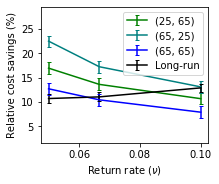

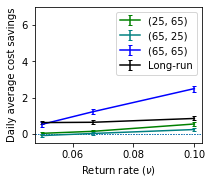

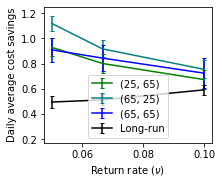

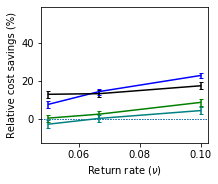

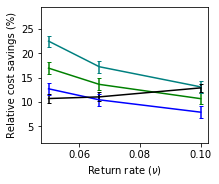

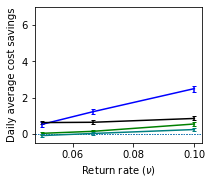

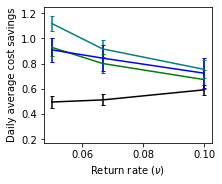

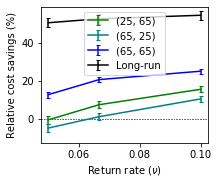

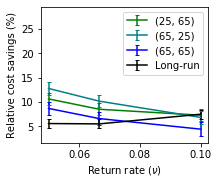

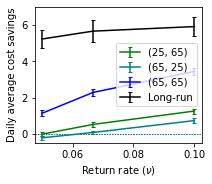

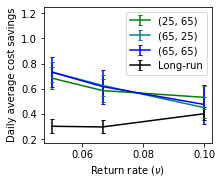

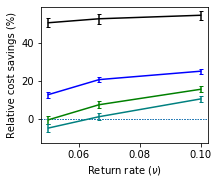

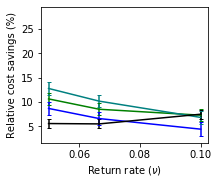

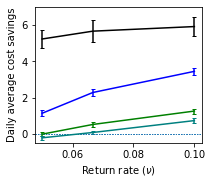

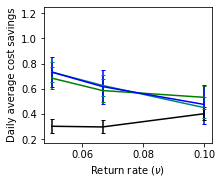

In [21]:
# Plot separately, for export

xlabel = r"Return rate ($\nu$)"
xvar = "nu"

ylabels = {
    'eq_rel' : "Relative cost savings (%)",
    'simple_rel' : "Relative cost savings (%)",
    'eq' : "Daily average cost savings",
    'simple' : "Daily average cost savings"
}
ylims = {
    var_name : [(new_df['raw_{}'.format(var_name)] - 2*new_df['below_{}'.format(var_name)]).min(),
              (new_df['raw_{}'.format(var_name)] + 2*new_df['above_{}'.format(var_name)]).max()] \
    for var_name in ylabels
}


def save_errorbars(data, var_name, fig_name, legend=False):
    
    fig, ax = plt.subplots()
    for j, init in enumerate(inits[1:]):
        subset = data[data.init == init].sort_values(by=xvar)
        ax.errorbar(subset[xvar], subset['raw_{}'.format(var_name)],
                    yerr=[subset['below_{}'.format(var_name)], subset['above_{}'.format(var_name)]],
                   capsize=2,
                   color=grays[j],
                   label=init)
        plt.ylim(ylims[var_name])
        ax.axhline(0, linewidth=1, linestyle='dotted')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabels[var_name])
        
        fig.set_figheight(2.5)
        fig.set_figwidth(3)
        
        if legend:
            ax.legend()
            plt.savefig(outdir + 'legend_{}_{}_{}.pdf'.format(typ, var_name, fig_name), bbox_inches='tight')
        else:
            plt.savefig(outdir + '{}_{}_{}.pdf'.format(typ, var_name, fig_name), bbox_inches='tight')

for i, val in enumerate(rates):
    fig_name = 'rate_{}'.format(val)
    bigset = new_df[new_df.rate == val]
    for legend in [True, False]:
        save_errorbars(bigset, 'eq_rel', fig_name, legend)
        save_errorbars(bigset, 'simple_rel', fig_name, legend)
        save_errorbars(bigset, 'eq', fig_name, legend)
        save_errorbars(bigset, 'simple', fig_name, legend)

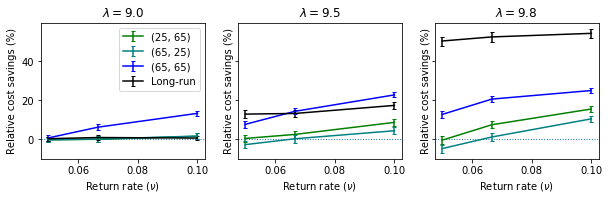

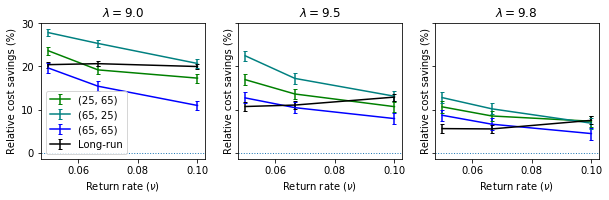

In [22]:
# Plot all together, for Python interpretation
fig, axes = plt.subplots(1, len(rates), sharey=True)
for i, rate in enumerate(rates):
    ax = axes[i]
    for j, init in enumerate(inits[1:]):
        subset = new_df[(new_df.rate == rate) & (new_df.init==init)].sort_values(by='nu')
        ax.errorbar(subset.nu, subset.raw_eq_rel, yerr=[subset.below_eq_rel, subset.above_eq_rel],
                    capsize=2,
                    color=grays[j],
                    label=init)
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Return rate ($\nu$)")
    ax.set_ylabel("Relative cost savings (%)")
    ax.title.set_text(r'$\lambda={}$'.format(rate))
    
    if i == 0:
        ax.legend()

    
fig.set_figheight(2.5)
fig.set_figwidth(10)
# plt.savefig(outdir + "rel_eq_rate_{}.pdf".format(typ), bbox_inches='tight')

fig, axes = plt.subplots(1, len(rates), sharey=True)
for i, rate in enumerate(rates):
    ax = axes[i]
    for j, init in enumerate(inits[1:]):
        subset = new_df[(new_df.rate == rate) & (new_df.init==init)].sort_values(by='nu')
        ax.errorbar(subset.nu, subset.raw_simple_rel, yerr=[subset.below_simple_rel, subset.above_simple_rel],
                    capsize=2,
                    color=grays[j],
                    label=init)
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Return rate ($\nu$)")
    ax.set_ylabel("Relative cost savings (%)")
    ax.title.set_text(r'$\lambda={}$'.format(rate))
    
    if i == 0:
        ax.legend()

    
fig.set_figheight(2.5)
fig.set_figwidth(10)
# plt.savefig(outdir + "rel_simple_rate_{}.pdf".format(typ), bbox_inches='tight')

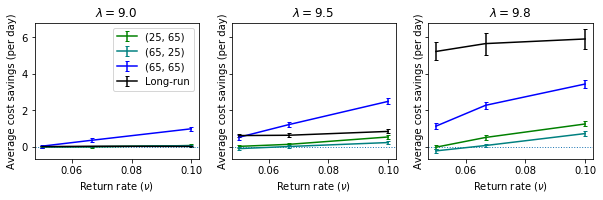

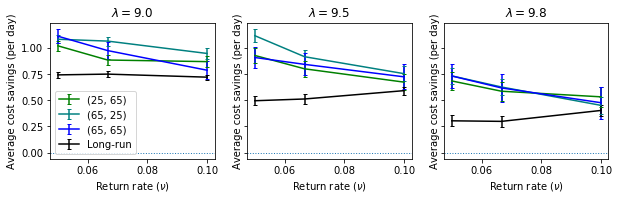

In [23]:
# Plot all together, for Python interpretation
fig, axes = plt.subplots(1, len(rates), sharey=True)
for i, rate in enumerate(rates):
    ax = axes[i]
    for j, init in enumerate(inits[1:]):
        subset = new_df[(new_df.rate == rate) & (new_df.init==init)].sort_values(by='nu')
        ax.errorbar(subset.nu, subset.raw_eq, yerr=[subset.below_eq, subset.above_eq],
                    capsize=2,
                    color=grays[j],
                    label=init)
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Return rate ($\nu$)")
    ax.set_ylabel("Average cost savings (per day)")
    ax.title.set_text(r'$\lambda={}$'.format(rate))
    
    if i == 0:
        ax.legend()

    
fig.set_figheight(2.5)
fig.set_figwidth(10)
# plt.savefig(outdir + "abs_eq_rate_{}.pdf".format(typ), bbox_inches='tight')

# Plot all together, for Python interpretation
fig, axes = plt.subplots(1, len(rates), sharey=True)
for i, rate in enumerate(rates):
    ax = axes[i]
    for j, init in enumerate(inits[1:]):
        subset = new_df[(new_df.rate == rate) & (new_df.init==init)].sort_values(by='nu')
        ax.errorbar(subset.nu, subset.raw_simple, yerr=[subset.below_simple, subset.above_simple],
                    capsize=2,
                    color=grays[j],
                    label=init)
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Return rate ($\nu$)")
    ax.set_ylabel("Average cost savings (per day)")
    ax.title.set_text(r'$\lambda={}$'.format(rate))
    
    if i == 0:
        ax.legend()

    
fig.set_figheight(2.5)
fig.set_figwidth(10)
# plt.savefig(outdir + "abs_simple_rate_{}.pdf".format(typ), bbox_inches='tight')

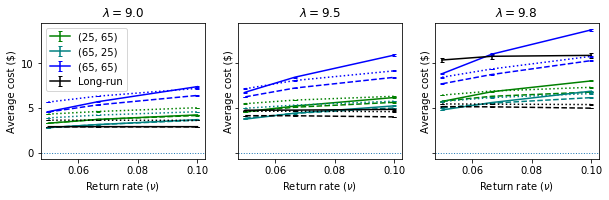

In [24]:
# Plot all together, for Python interpretation
fig, axes = plt.subplots(1, len(rates), sharey=True)
for i, rate in enumerate(rates):
    ax = axes[i]
    for j, init in enumerate(inits[1:]):
        subset = new_df[(new_df.rate == rate) & (new_df.init==init)].sort_values(by='nu')
        ax.errorbar(subset.nu, subset.opt_mean, yerr=subset.opt_ci,
                    capsize=2,
                    color=grays[j],
                    linestyle='--')
        ax.errorbar(subset.nu, subset.eq_mean, yerr=subset.eq_ci,
                    capsize=2,
                    color=grays[j],
                    label=init)
        ax.errorbar(subset.nu, subset.simple_mean, yerr=subset.simple_ci,
                   capsize=2,
                   color=grays[j],
                   linestyle=':')
    ax.axhline(0, linewidth=1, linestyle='dotted')
    ax.set_xlabel(r"Return rate ($\nu$)")
    ax.set_ylabel("Average cost ($)")
    ax.title.set_text(r'$\lambda={}$'.format(rate))
    
    if i == 0:
        ax.legend()

    
fig.set_figheight(2.5)
fig.set_figwidth(10)